In [1]:
import nixio
import pandas as pd
import neo
import quantities as pq
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import xarray as xr
from frites.dataset import DatasetEphy
from frites.workflow import WfMi
import sklearn as sk
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
px = pq.UnitQuantity('px', pq.dimensionless, symbol='px') 
fps = pq.UnitQuantity('fps', pq.Hz, symbol='fps')

path_nix = '../data/nix_files/'
filename = 'subj_01_day_3_r_epo.nix'
with neo.io.NixIO(path_nix + filename, 'ro') as io:
    nix_data = io.read_block()

In [3]:
roi_names = pd.read_csv('../data/anat/aal_01_elecs2ROI.csv').columns
centroids = pd.read_csv('../data/anat/aal_01_ROIcentroids_Lside.csv').values

In [4]:
nix_data.segments[0].annotations.keys()

dict_keys(['nix_name', 'time', 'event_timestamp', 'mvmt', 'vid_name', 'event_frame_idx', 'false_pos', 'patient_id', 'I_over_C_ratio', 'audio_ratio', 'reach_duration', 'reach_r', 'reach_a', 'onset_velocity', 'other_reach_overlap', 'bimanual', 'other_lead_lag'])

In [5]:
n_trials = len(nix_data.segments)
data = np.stack([nix_data.segments[i].analogsignals[0].magnitude for i in range(n_trials)])    # Epochs data
angle = np.stack([nix_data.segments[i].annotations['reach_duration'] for i in range(n_trials)])       # Reach angle
data = data.transpose(0,2,1)
data.shape

(156, 94, 5501)

(array([18., 33., 42., 29., 15.,  7.,  6.,  3.,  2.,  1.]),
 array([0.33333333, 0.64333333, 0.95333333, 1.26333333, 1.57333333,
        1.88333333, 2.19333333, 2.50333333, 2.81333333, 3.12333333,
        3.43333333]),
 <BarContainer object of 10 artists>)

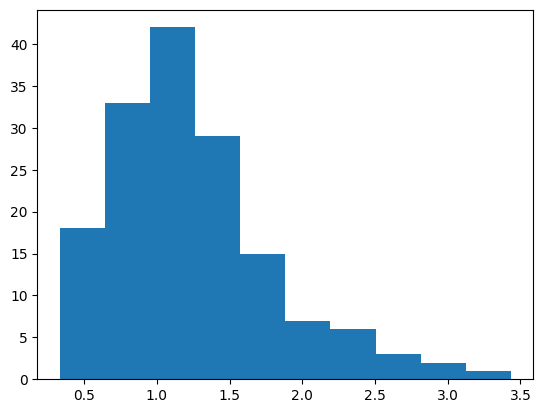

In [6]:
plt.hist(angle / 30)

In [24]:
behavioral

{'I_over_C_ratio': 0.0296679099,
 'audio_ratio': 0.1739951808,
 'reach_duration': 29,
 'reach_r': 56.0681077424,
 'reach_a': -152.3603329033,
 'onset_velocity': 3.1337075799,
 'bimanual': 0}

In [8]:
x = nix_data.segments[1].analogsignals[0].array_annotations['chanlocs_x']
y = nix_data.segments[1].analogsignals[0].array_annotations['chanlocs_y']
z = nix_data.segments[1].analogsignals[0].array_annotations['chanlocs_z']
time = nix_data.segments[1].analogsignals[0].times - 5.5 * pq.s

In [9]:
chanlocs = np.stack((x,y,z), axis=1)
euc_dist = euclidean_distances(chanlocs, centroids)
roi_names = roi_names[np.argmin(euc_dist, axis = 1)]

In [10]:
data = xr.DataArray(data, dims=("trials", "roi", "times"), coords={"trials": angle, "times": time, "roi": roi_names})
data.attrs["chanlocs_x"] = x
data.attrs["chanlocs_y"] = y
data.attrs["chanlocs_z"] = z

In [34]:
bhv_names = ['bimanual', 'onset_velocity', 'reach_r', 'reach_a',  'I_over_C_ratio', 'audio_ratio', 'reach_duration']

behavioral = np.zeros((data.sizes["trials"], len(bhv_names)))

for trial in range(data.sizes["trials"]):
    for key, item in nix_data.segments[trial].annotations.items():
        pos = 0
        if key in bhv_names:
            behavioral[trial, pos] = item
            pos = pos + 1

In [35]:
behavioral

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
 

In [12]:
is_good_channel = nix_data.segments[1].analogsignals[0].array_annotations['is_good_channel']
is_false_positive = np.logical_not([nix_data.segments[i].annotations['false_pos'] for i in range (len(nix_data.segments))])


data = data.isel(roi = is_good_channel, trials = is_false_positive)

In [13]:
centroids.shape

(116, 3)

In [14]:
ds = DatasetEphy( [data.isel(roi=[i]) for i in range(data.sizes["roi"])] , y='trials', roi='roi', times='times', nb_min_suj=2)

# """
# define the type of mutual information to compute
# 'cd' = I(continuous; discret)
#      = I(brain data; stimulus)
# """
mi_type = 'cc'

# define a workflow of mutual-information
wf = WfMi(mi_type=mi_type, inference='rfx')

# run the workflow (without stat for the moment)
mi, pv = wf.fit(ds, mcp='fdr', n_perm = 500)

Definition of an electrophysiological dataset
    Dataset composed of 85 subjects / sessions
    At least 2 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=False, biascorrect=True, demeaned=False)
Definition of a non-parametric statistical workflow
Workflow for computing mutual information (inference=rfx, mi_type=cc, copnorm=True)
    Evaluate true and permuted mi (n_perm=500, n_jobs=-1)
/home/koehler/anaconda3/envs/andani_arm_movements/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|█████████████████████████| Estimating MI : 15/15 [10:05<00:00,   40.39s/it]
    T-test across subjects (pop_mean=2.081488866460773e-06; center=False; zscore=False; sigma=0.001)
    Inference at spatio-temporal level (test-wise)

In [15]:
wf.tvalues

<xarray.DataArray 'tvalues' (times: 5501, roi: 15)> Size: 330kB
array([[-4.0781283e+00,  8.3168828e-01,  4.8227429e-01, ...,
        -1.3845064e-01,  2.4694628e-01, -4.0030413e+00],
       [-3.4267938e+00,  8.6472279e-01, -6.1216176e-01, ...,
         4.7970694e-01, -6.0881797e-02, -4.4314346e+00],
       [-1.5447198e+00,  7.4575549e-01, -1.9305575e+00, ...,
         4.9598819e-01, -2.9085050e-03, -2.4147277e+00],
       ...,
       [ 5.2111936e-01, -1.2042004e+00,  2.2055209e+00, ...,
        -3.6923060e+00, -2.7828500e+00, -3.0697162e+00],
       [ 5.7041150e-01, -9.3716222e-01,  2.2730422e+00, ...,
        -3.4599814e+00, -2.6519763e+00, -1.8342282e+00],
       [ 4.2757395e-01, -1.0827053e+00,  8.9543700e-01, ...,
        -2.8833907e+00, -1.4582002e+00, -3.6765728e-02]], dtype=float32)
Coordinates:
  * times    (times) float64 44kB -5.5 -5.498 -5.496 -5.494 ... 5.496 5.498 5.5
  * roi      (roi) <U19 1kB 'Frontal_Mid_L' 'Precentral_L' ... 'Occipital_Inf_L'
Attributes: (12/14)
    mi_type:         cc
    inference:       rfx
    kernel:          None
    ttest_pop_mean:  2.081488866460773e-06
    ttest_sigma:     0.001
    ttest_center:    0
    ...              ...
    cluster_th:      None
    cluster_alpha:   0.05
    ttested:         0
    n_perm:          500
    random_state:    None
    type:            tvalues

In [16]:
mi_corr = mi * (pv <= .01)

In [17]:
(mi_corr > 0).any("times")

<xarray.DataArray (roi: 15)> Size: 15B
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])
Coordinates:
  * roi      (roi) <U19 1kB 'Frontal_Mid_L' 'Precentral_L' ... 'Occipital_Inf_L'

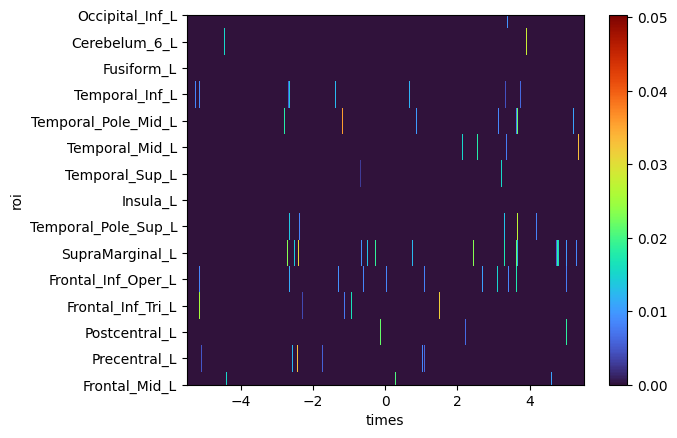

In [18]:
mi_corr.plot(x="times", y="roi", cmap="turbo");
# plt.xlim(4, 5)

In [19]:
mi_corr.to_netcdf('subject1_mi.nc')

In [21]:
(wf.tvalues * (pv <= .01)).to_netcdf('subject1_tvalues.nc')

In [263]:
from spectral import conn_spec_average
from surrogates import trial_swap_surrogates

In [258]:
data_conn = data.groupby("roi").mean("roi")

In [272]:
data_conn_surr = [trial_swap_surrogates(data_conn) for i in range(10)]

In [259]:
coh = conn_spec_average(data_conn, 3, 60, roi="roi", sfreq=500, bandwidth=3)

WARNING | No time vector. A default one is created
Defining links (n_roi=21; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise coh (n_pairs=210, decim=1


    Using multitaper spectrum estimation with 31 DPSS windows


100%|████████████████████████████████████|  : 210/210 [00:03<00:00,   56.45it/s]


In [273]:
coh_sur = [conn_spec_average(_data_conn_surr, 3, 60, roi="roi", sfreq=500, bandwidth=3, n_jobs=4) for _data_conn_surr in data_conn_surr]

WARNING | No time vector. A default one is created
Defining links (n_roi=21; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise coh (n_pairs=210, decim=1


    Using multitaper spectrum estimation with 31 DPSS windows


100%|████████████████████████████████████|  : 210/210 [00:02<00:00,   70.35it/s]
WARNING | No time vector. A default one is created
Defining links (n_roi=21; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise coh (n_pairs=210, decim=1


    Using multitaper spectrum estimation with 31 DPSS windows


100%|████████████████████████████████████|  : 210/210 [00:03<00:00,   61.99it/s]
WARNING | No time vector. A default one is created
Defining links (n_roi=21; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise coh (n_pairs=210, decim=1


    Using multitaper spectrum estimation with 31 DPSS windows


100%|████████████████████████████████████|  : 210/210 [00:02<00:00,   79.65it/s]
WARNING | No time vector. A default one is created
Defining links (n_roi=21; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise coh (n_pairs=210, decim=1


    Using multitaper spectrum estimation with 31 DPSS windows


100%|████████████████████████████████████|  : 210/210 [00:03<00:00,   54.25it/s]
WARNING | No time vector. A default one is created
Defining links (n_roi=21; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise coh (n_pairs=210, decim=1


    Using multitaper spectrum estimation with 31 DPSS windows


100%|████████████████████████████████████|  : 210/210 [00:02<00:00,   72.01it/s]
WARNING | No time vector. A default one is created
Defining links (n_roi=21; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise coh (n_pairs=210, decim=1


    Using multitaper spectrum estimation with 31 DPSS windows


100%|████████████████████████████████████|  : 210/210 [00:02<00:00,   73.19it/s]
WARNING | No time vector. A default one is created
Defining links (n_roi=21; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise coh (n_pairs=210, decim=1


    Using multitaper spectrum estimation with 31 DPSS windows


100%|████████████████████████████████████|  : 210/210 [00:02<00:00,   75.78it/s]
WARNING | No time vector. A default one is created
Defining links (n_roi=21; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise coh (n_pairs=210, decim=1


    Using multitaper spectrum estimation with 31 DPSS windows


100%|████████████████████████████████████|  : 210/210 [00:02<00:00,   71.79it/s]
WARNING | No time vector. A default one is created
Defining links (n_roi=21; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise coh (n_pairs=210, decim=1


    Using multitaper spectrum estimation with 31 DPSS windows


100%|████████████████████████████████████|  : 210/210 [00:03<00:00,   62.81it/s]
WARNING | No time vector. A default one is created
Defining links (n_roi=21; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise coh (n_pairs=210, decim=1


    Using multitaper spectrum estimation with 31 DPSS windows


100%|████████████████████████████████████|  : 210/210 [00:02<00:00,   80.00it/s]


In [294]:
coh_surr_thr = xr.concat(coh_sur, "surr").quantile(.95, "surr")

In [295]:
from frites.conn.conn_utils import conn_reshape_undirected
from frites.plot import plot_conn_circle, plot_conn_heatmap

In [296]:
A = conn_reshape_undirected(np.clip(coh - coh_surr_thr, 0, 1), fill_diagonal=0, fill_value=0).sel(freqs=slice(15, 20)).mean("freqs")

/home/koehler/anaconda3/envs/andani_arm_movements/lib/python3.11/site-packages/frites/conn/conn_utils.py:520: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'roi' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  da[axis] = pd.MultiIndex.from_arrays(


<Axes: >

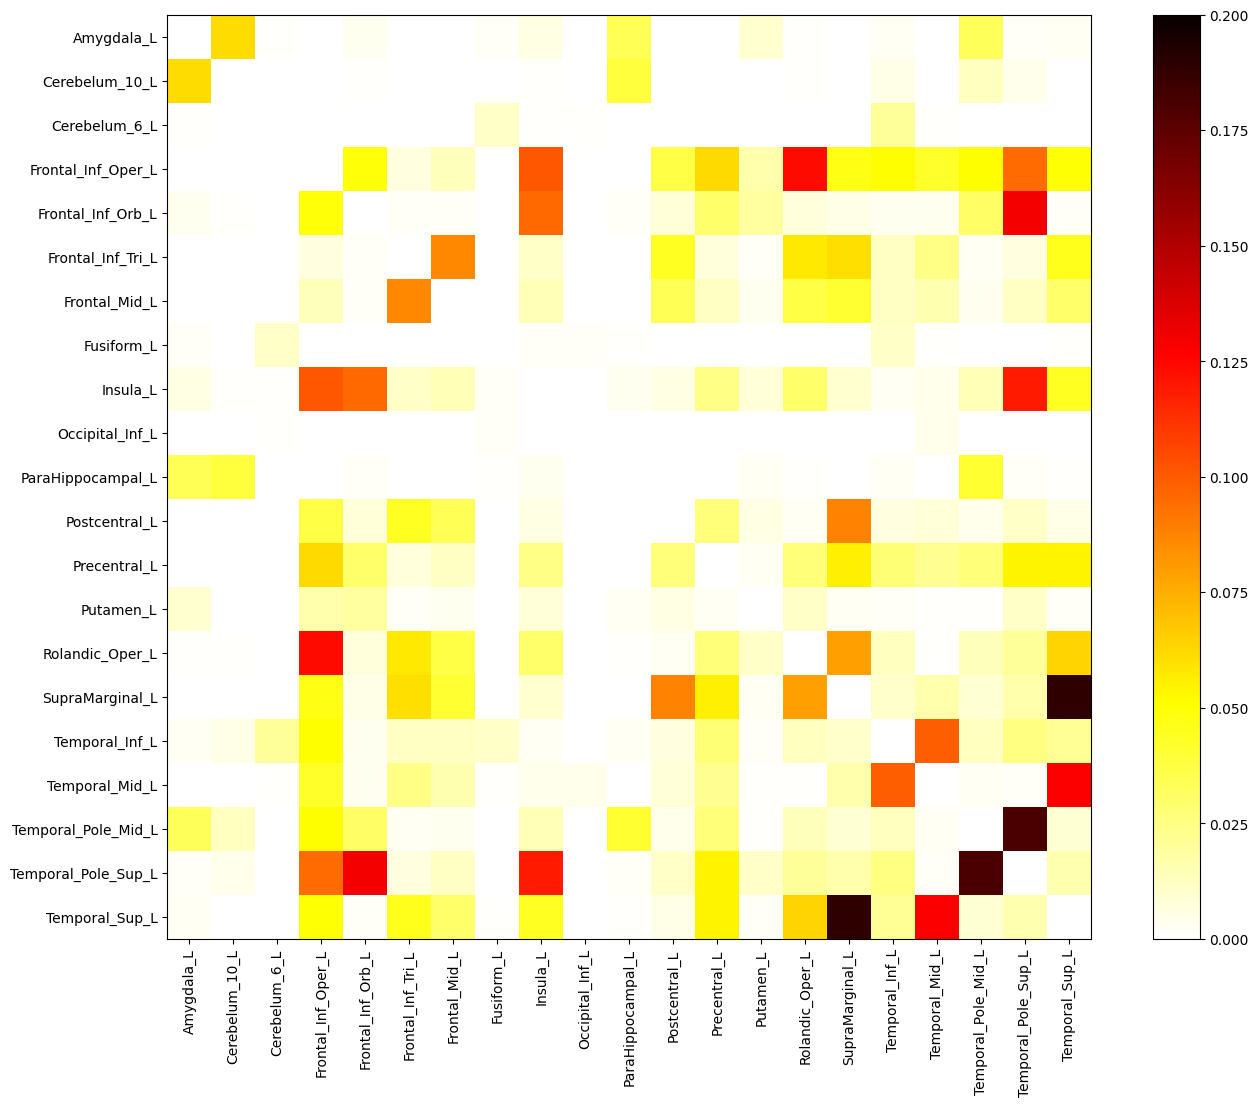

In [297]:
plot_conn_heatmap(A, cmap="hot_r", vmin=0, vmax=.2)

In [337]:
from frites.core import gccmi_nd_ccc, gccmi_1d_ccc, gcmi_1d_cc

In [331]:
x = data_conn[:, 20]
y = data_conn[:, 10]
z = data_conn.trials.values

In [ ]:
gccmi_1d_ccc(x.values.T, y.values.T, z, biascorrect=False)